# Module 2

### Imports

In [33]:
import cv2
import glob
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import os, random
import pathlib
from PIL import Image
import imageio
from skimage import color, feature
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from tqdm import tqdm

### Helpers

In [34]:
def determine_class(file_dir, classes):
    path = np.char.split(file_dir, sep ='\\')
    file_name = path.item(0)[-1]
    for i in range(0, len(classes)):
        if classes[i] in file_name:
            return i
    return -1

### Feature Extractors

In [35]:
def extract_rgb(image):
    r, g, b = cv2.split(image)
    
    norm_r = normalize(r, norm='l2')
    norm_g = normalize(g, norm='l2')
    norm_b = normalize(b, norm='l2')
    
    return np.array([np.mean(norm_r), np.mean(norm_g), np.mean(norm_b), np.std(norm_r), np.std(norm_g), np.std(norm_b)], dtype=np.float32)

def extract_hsv(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(image)
    
    norm_h = normalize(h, norm='l2')
    norm_s = normalize(s, norm='l2')
    norm_v = normalize(v, norm='l2')
    
    
    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(h, cv2.COLOR_BGR2RGB))
    plt.xlabel('H')
    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(s, cv2.COLOR_BGR2RGB))
    plt.xlabel('S')
    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(v, cv2.COLOR_BGR2RGB))
    plt.xlabel('V')
    
    return np.array([np.mean(norm_h), np.mean(norm_s), np.mean(norm_v), np.std(norm_h), np.std(norm_s), np.std(norm_v)], dtype=np.float32)

def extract_lab(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b= cv2.split(image)
    
    norm_l = normalize(l, norm='l2')
    norm_a = normalize(a, norm='l2')
    norm_b = normalize(b, norm='l2')
    
    return np.array([np.mean(norm_l), np.mean(norm_a), np.mean(norm_b), np.std(norm_l), np.std(norm_a), np.std(norm_b)], dtype=np.float32)

def extract_glcm(image):
    offset = [1] #pixel
    directions = np.asarray([np.pi*i/4 for i in range(0, 8)]) #radian angles

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = feature.greycomatrix(image, distances=offset, angles=directions).astype(np.uint8)
    
    contrast = feature.greycoprops(glcm, prop='contrast')
    homogeneity = feature.greycoprops(glcm, prop='homogeneity')
    energy = feature.greycoprops(glcm, prop='energy')
    correlation = feature.greycoprops(glcm, prop='correlation')
    
    norm_contrast = normalize(contrast, norm='l2')
    norm_homogeneity = normalize(homogeneity, norm='l2')
    norm_energy = normalize(energy, norm='l2')
    norm_correlation = normalize(correlation, norm='l2')
    
    return np.array([np.mean(norm_contrast), np.mean(norm_homogeneity), np.mean(norm_energy), np.mean(norm_correlation), np.std(norm_contrast), np.std(norm_homogeneity), np.std(norm_energy), np.std(norm_correlation)], dtype=np.float32)

### Load Images

In [40]:
current_dir = os.getcwd()
data_dir = current_dir + '\\data_original\\Tumor' #should be from '\data_augmented'
image_files = glob.glob(data_dir + '/*.png')

classes = np.array(['Necrosis', 'Stroma', 'Tumor'])

augmented_images_size = (512, 512, 3)
augmented_images = np.empty((0, augmented_images_size[0], augmented_images_size[1], augmented_images_size[2]), dtype=np.uint8)
augmented_labels = np.empty((0,), dtype=np.uint8)
augmented_images_files = np.empty((0, 1))

for current_image_file in tqdm(image_files):   
    current_image = np.expand_dims(np.array(Image.open(current_image_file)).astype(np.uint8), axis=0)    
    current_image_label = determine_class(current_image_file, classes)

    augmented_images = np.append(augmented_images, current_image, axis=0)
    augmented_labels = np.append(augmented_labels, np.expand_dims(current_image_label, axis=0), axis=0)

    current_image_file = np.expand_dims(current_image_file, axis=0)
    augmented_images_files = np.append(augmented_images_files, np.expand_dims(current_image_file, axis=0), axis=0)
    
print()
print('Images:', augmented_images.shape)
print('Labels:', augmented_labels.shape)
print('Files:', augmented_images_files.shape)


Images: (100, 512, 512, 3)
Labels: (100,)
Files: (100, 1)


### Extract Features

Data Features: (1, 26)
Data Labels: (1,)


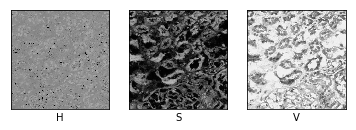

In [41]:
num_features = 6 + 6 + 6 + 8 #D

data_features = np.empty((0, num_features), dtype=np.float32) #NxD
data_labels = np.empty((0,), dtype=np.uint8) #1xD

for i in tqdm(range(0, 1)): #augmented_images.shape[0])):
    current_data_features = np.array([], dtype=np.float32)
        
    out = extract_rgb(augmented_images[i])
    current_data_features = np.append(current_data_features, out, axis=0)
    
    out = extract_hsv(augmented_images[i])
    current_data_features = np.append(current_data_features, out, axis=0)

    out = extract_lab(augmented_images[i])
    current_data_features = np.append(current_data_features, out, axis=0)
    
    out = extract_glcm(augmented_images[i])
    current_data_features = np.append(current_data_features, out, axis=0)
    
    data_features = np.append(data_features, np.expand_dims(current_data_features, axis=0), axis=0)
    data_labels = np.append(data_labels, np.expand_dims(augmented_labels[i], axis=0), axis=0)

print('Data Features:', data_features.shape)
print('Data Labels:', data_labels.shape)

In [22]:
print(data_features)

[[0.04398049 0.04266826 0.04363985 0.00434068 0.01151278 0.00697772
  0.04407357 0.03931944 0.04402243 0.00326273 0.02017689 0.00389242
  0.04338927 0.04407577 0.04373204 0.00839622 0.00323288 0.00637449
  0.32264647 0.348883   0.35213572 0.35340744 0.14456578 0.05727689
  0.03162951 0.01015728]
 [0.04359284 0.040979   0.04287463 0.00726563 0.01654831 0.01071873
  0.04374699 0.03470598 0.04365939 0.00627107 0.02736092 0.00685438
  0.04231538 0.04396598 0.04350252 0.01274888 0.00448529 0.0077882
  0.33490285 0.34667945 0.3520144  0.35351092 0.11331411 0.06937833
  0.03295244 0.00547938]
 [0.04359346 0.04282328 0.04371792 0.00726192 0.01092209 0.00647061
  0.04403346 0.0390307  0.04377677 0.00376552 0.02072991 0.0060597
  0.04337629 0.04411288 0.04396128 0.00846302 0.00267931 0.00453112
  0.33896217 0.35012397 0.35261998 0.35347542 0.10052188 0.04912441
  0.02567388 0.00742407]
 [0.04379491 0.04286581 0.04371265 0.00592715 0.01075393 0.00650611
  0.0437402  0.03431401 0.04383972 0.006318

### Plot Features

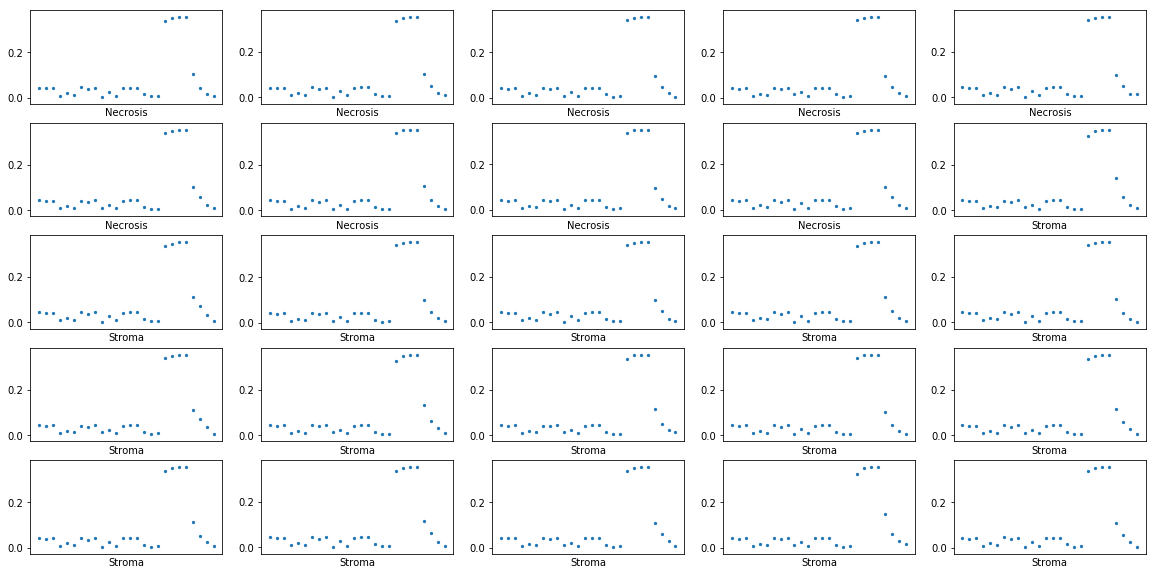

In [7]:
grid = (5, 5)

ax = plt.figure(figsize=(20, 10))

for i in tqdm(range(0, data_features.shape[0])):
    plt.subplot(grid[0], grid[1], i+1)
    plt.xticks([])
#     plt.yticks([])
    plt.grid(False)
    plt.scatter(range(0, num_features), data_features[i, :], s=5)
    plt.xlabel(classes[data_labels[i]])